# *Разведывательный анализ данных*

Очень часто бывает так, что способный ребенок начинает отставать от успеваемости, при этом родители могут прикладывать все усилия для развития и обучения своего чада, однако, не всегда идет так, как ожидают. Конечно, объяснением этому могут быть разные причины, немаловажную роль играют такие факторы, как повседневная среда и окружение, друзья учащегося, здоровье, отношения в семье и т.д. 

Целью этого проекта является анализ набора данных, состоящего из сведений об учащихся в возрасте от 15 до 22 лет.

Задачей этого анализа, является выявление факторов, которые действительно могут повлиять на успеваемость учащегося.

<img src="http://ogo.ua/images/articles/1/big/1526926394.jpg">

## Импортирование библиотек и загрузка исходного набора данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind, normaltest
import warnings
warnings.filterwarnings('ignore')

stud = pd.read_csv('stud_math.csv')

In [2]:
stud.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,...,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,...,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,...,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,...,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,...,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


In [3]:
stud.rename(
    columns={"studytime, granular": "studytime_granular"}, inplace=True)

## Дополнительные функции, для анализ данных

In [4]:
# функция для получения основной информациии для номинативных переменных
def info_kategorial(x):
    print('Количество пропущенных значений:', pd.isnull(x).sum())
    print('Количество уникальных значений:', pd.DataFrame(x).nunique()[0])
    display(pd.DataFrame(pd.value_counts(x)))

# функция для получения основной информации для числовых переменных


def info_digital(x):
    print('Количество пропущенных значений:', pd.isnull(x).sum())
    print('\nРасспределение уникальных значений:')
    display(pd.DataFrame(pd.value_counts(x)))
    print('Основная статистика:')
    display(pd.DataFrame(x.describe()))
    plt.hist(x)
    plt.title('Гистограмма')

# создание словаря для замены для номинальных переменных Medu, Fedu, Mjob, Fjob


def dict_for_replace(s, group):
    d = {}
    for i in s:
        d[i] = group.loc[i].idxmax()[0]
    return(d)

# функция для исследония данных на выбросы


def vubros(x):
    median = pd.DataFrame(x).median()[0]
    IQR = pd.DataFrame(x).quantile(0.75)[0] - pd.DataFrame(x).quantile(0.25)[0]
    perc25 = pd.DataFrame(x).quantile(0.25)[0]
    perc75 = pd.DataFrame(x).quantile(0.75)[0]
    df = pd.Series(x).loc[pd.Series(x).between(
        perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    plt.hist(df, bins=10, range=(0, (perc75 + 1.5*IQR)*1.2), label='IQR')
    plt.legend()

# функция, возвращающая границы для удаления выбросов


def interval_vaubros(x):
    median = pd.DataFrame(x).median()[0]
    IQR = pd.DataFrame(x).quantile(0.75)[0] - pd.DataFrame(x).quantile(0.25)[0]
    perc25 = pd.DataFrame(x).quantile(0.25)[0]
    perc75 = pd.DataFrame(x).quantile(0.75)[0]
    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR
    return(f, l)

# функция для проверки распределение случайной величины по нормальному закону


def test_normal(x, alpha):
    print('H0: случайная величина подчиняется нормальному закону')
    print('H1: случайная величина не распределена по нормальному закону')
    print('Уровень значимости:', alpha)
    print('----------------------------------------------------------------------------')
    x = np.array(x, dtype=float)
    stat = normaltest(x)
    pvalue = stat.pvalue
    print('p-value:', stat.pvalue)

    if alpha > pvalue:
        print('H0 отклоняется, H1 принимается - случайная величина не подчиняется нормальному закону')
    else:
        print('H0 принимается, H1 отклоняется - случайная величина распределена по нормальному закону')

## Первичный осмотр данных

In [5]:
print(
    f'Набор данных содержит {stud.shape[0]} строк и {stud.shape[1]} столбцов.')

Набор данных содержит 395 строк и 30 столбцов.


In [6]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   Pstatus             350 non-null    object 
 6   Medu                392 non-null    float64
 7   Fedu                371 non-null    float64
 8   Mjob                376 non-null    object 
 9   Fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

Все столбцы содержат пропущенные значения, кроме столбцов scool, sex, age.

## school

Столбец содержит данные, о школе в которой учится ученик, в виде аббревиатуры. Рассмотрим сколько уникальных значений содержит
данный столбец.

In [7]:
info_kategorial(stud.school)

Количество пропущенных значений: 0
Количество уникальных значений: 2


,school
GP,349
MS,46


In [8]:
stud.school.value_counts(normalize=True)

GP    0.883544
MS    0.116456
Name: school, dtype: float64

Приблизительно 88% учатся в GP и только 12% в MS. Выбросов нет.

## sex 

Столбец sex содержит данные пола ученика ('F' - женский, 'M' - мужской)

In [9]:
info_kategorial(stud.sex)

Количество пропущенных значений: 0
Количество уникальных значений: 2


,sex
F,208
M,187


По данным видно, что выборка содержит приблизительно одинаковое количество мальчиков и девочек.Выбросов нет

## age

В столбце age находятся данные о возрасте учащихся от 15 до 22 лет.

Количество пропущенных значений: 0

Расспределение уникальных значений:


,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1


Основная статистика:


,age
count,395.000000
mean,16.696203
std,1.276043
min,15.000000
25%,16.000000
50%,17.000000
75%,18.000000
max,22.000000


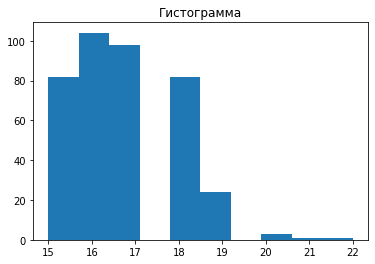

In [10]:
info_digital(stud.age)

Все значения находятся в пределах от 15 до 22. Следовательно выбросов нет.

## address 

 Столбец содержит тип адреса ученика ('U' - городской, 'R' - за городом)

In [11]:
info_kategorial(stud.address)

Количество пропущенных значений: 17
Количество уникальных значений: 2


,address
U,295
R,83


Так как признак номинальный, то заменим пропущенные значения на моду.

In [12]:
t = stud['address'].mode()
stud.address.fillna(stud['address'].mode()[0], inplace=True)

In [13]:
stud.address.isnull().sum()

0

Выбросов нет.

## famsize

famsize = размер семьи('LE3' <= 3, 'GT3' >3)

In [14]:
info_kategorial(stud.famsize)

Количество пропущенных значений: 27
Количество уникальных значений: 2


,famsize
GT3,261
LE3,107


Так как признак номинальный, то заменим пропущенные значения на моду.

In [15]:
stud.famsize.fillna(stud.famsize.mode()[0], inplace=True)

In [16]:
stud.famsize.isnull().sum()

0

Выбросов нет.

## Pstatus 

Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [17]:
info_kategorial(stud.Pstatus)

Количество пропущенных значений: 45
Количество уникальных значений: 2


,Pstatus
T,314
A,36


In [18]:
stud.Pstatus.fillna(stud.Pstatus.mode()[0], inplace=True)

In [19]:
stud.Pstatus.isnull().sum()

0

Выбросов нет.

## Medu

Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [20]:
info_kategorial(stud.Medu)

Количество пропущенных значений: 3
Количество уникальных значений: 5


,Medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


Заменяем пропущенные значения. В данном случае нет, какой то ярковыраженной моды. Рассмотрим как совместно распределены значения образования и работы.

In [21]:
group_mather_edu = pd.DataFrame(stud.groupby(
    ['Mjob', 'Medu'])['Mjob'].agg(['count']))
group_mather_edu

count
Mjob     Medu       
at_home  0.0       2
         1.0      25
         2.0      21
         3.0       8
         4.0       2
health   1.0       1
         2.0       2
         3.0       5
         4.0      24
other    0.0       1
         1.0      26
         2.0      45
         3.0      37
         4.0      22
services 1.0       5
         2.0      30
         3.0      38
         4.0      24
teacher  3.0       3
         4.0      52

Проверим совпадают ли пропущенные значения по строкам в каждом столбце одновременно

In [22]:
stud[stud.Medu.isnull() & stud.Mjob.isnull()].shape[0]

0

Строк имеющих одновременно пропущенных значений в столбцах Medu и Mjob нет. Составим словарь для замены пустых значений, по каждому типу образования, исходя из работы отца. Т.е. найдем максимум столбца count для Medu по каждой профессии. 

In [23]:
# создаем словарь для замены
s1 = stud[stud['Mjob'].notnull()].Mjob.unique().tolist()
d1 = dict_for_replace(s1, group_mather_edu)
d1

{'at_home': 1.0, 'health': 4.0, 'other': 2.0, 'services': 3.0, 'teacher': 4.0}

In [24]:
# исходная выборка с нулевыми значениями
df2 = stud[stud.Medu.isnull()]
df2

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
92,GP,F,16,U,LE3,T,NaN,1.0,other,other,...,-6.0,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
193,GP,M,16,R,GT3,T,NaN,3.0,services,services,...,-3.0,yes,yes,no,4.0,3.0,2.0,5.0,8.0,50.0
239,GP,M,18,U,GT3,T,NaN,2.0,other,services,...,-6.0,no,NaN,NaN,5.0,5.0,4.0,2.0,0.0,0.0


In [25]:
# Заменяем нулевые значение значениями из словаря
stud.loc[stud['Medu'].astype(str).isin(['Nan', 'nan']), 'Medu'] = stud.loc[stud['Medu'].astype(
    str).isin(['Nan', 'nan']), 'Mjob'].map(d1)

In [26]:
# Проверка
stud.loc[[92, 193, 239], ['Mjob', 'Medu']]

,Mjob,Medu
92,other,2.0
193,services,3.0
239,other,2.0


In [27]:
stud.Medu.isnull().sum()

0

Выбросов нет.

## Fedu 

Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [28]:
info_kategorial(stud.Fedu)

Количество пропущенных значений: 24
Количество уникальных значений: 6


,Fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


Значение 40.0 является ошибочным, заменим его на 4.0

In [29]:
stud.Fedu.replace(40.0, 4.0, inplace=True)

In [30]:
stud.Fedu.value_counts()

2.0    106
3.0     96
4.0     89
1.0     78
0.0      2
Name: Fedu, dtype: int64

С данным столбцом поступаем аналогично, как со столбцом Medu.

In [31]:
group_father = pd.DataFrame(stud.groupby(
    ['Fjob', 'Fedu'])['Fjob'].agg(['count']))
group_father

count
Fjob     Fedu       
at_home  1.0       3
         2.0       6
         3.0       3
         4.0       2
health   1.0       1
         2.0       1
         3.0       3
         4.0       8
other    0.0       2
         1.0      48
         2.0      58
         3.0      51
         4.0      31
services 1.0      19
         2.0      27
         3.0      31
         4.0      17
teacher  3.0       1
         4.0      25

In [32]:
# создаем словарь для замены
s2 = stud[stud['Fjob'].notnull()].Fjob.unique().tolist()
d2 = dict_for_replace(s2, group_father)
d2

{'teacher': 4.0, 'other': 2.0, 'health': 4.0, 'services': 3.0, 'at_home': 2.0}

In [33]:
# Заменяем нулевые значение значениями из словаря
stud.loc[stud['Fedu'].astype(str).isin(['Nan', 'nan']), 'Fedu'] = stud.loc[stud['Fedu'].astype(
    str).isin(['Nan', 'nan']), 'Fjob'].map(d2)

In [34]:
stud.Fedu.isnull().sum()

2

Осталось два нулевых значения, когда в обоих столбцах Fedu и Fjob стоит Nan

In [35]:
stud[stud.Fedu.isnull() & stud.Fjob.isnull()].shape[0]

2

In [36]:
stud.Fedu.value_counts()

2.0    115
3.0    104
4.0     94
1.0     78
0.0      2
Name: Fedu, dtype: int64

Заменим эти два значения на моду - '2.0'

In [37]:
stud['Fedu'].fillna(2.0, inplace=True)

In [38]:
stud.Fedu.isnull().sum()

0

## Mjob 

Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [39]:
info_kategorial(stud.Mjob)

Количество пропущенных значений: 19
Количество уникальных значений: 5


,Mjob
other,133
services,98
at_home,58
teacher,55
health,32


In [40]:
group_mather = pd.DataFrame(stud.groupby(
    ['Medu', 'Mjob'])['Medu'].agg(['count']))
group_mather

count
Medu Mjob           
0.0  at_home       2
     other         1
1.0  at_home      25
     health        1
     other        26
     services      5
2.0  at_home      21
     health        2
     other        47
     services     30
3.0  at_home       8
     health        5
     other        37
     services     39
     teacher       3
4.0  at_home       2
     health       24
     other        22
     services     24
     teacher      52

In [41]:
# создаем словарь для замены
s3 = stud[stud['Medu'].notnull()].Medu.unique().tolist()
d3 = dict_for_replace(s3, group_mather)
d3

{4.0: 'teacher', 1.0: 'other', 3.0: 'services', 2.0: 'other', 0.0: 'at_home'}

In [42]:
# Заменяем нулевые значение значениями из словаря
mask = stud['Mjob'].astype('str').isin(['NaN', 'nan', 'Nan'])
stud.loc[mask, 'Mjob'] = stud.loc[mask, 'Medu'].map(d3)

In [43]:
stud.Mjob.isnull().sum()

0

Выбросов нет.

## Fjob

Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [44]:
info_kategorial(stud.Fjob)

Количество пропущенных значений: 36
Количество уникальных значений: 5


,Fjob
other,197
services,102
teacher,29
at_home,16
health,15


In [45]:
group_father_job = pd.DataFrame(stud.groupby(
    ['Fedu', 'Fjob'])['Fedu'].agg(['count']))
group_father_job

count
Fedu Fjob           
0.0  other         2
1.0  at_home       3
     health        1
     other        48
     services     19
2.0  at_home       8
     health        1
     other        65
     services     27
3.0  at_home       3
     health        3
     other        51
     services     39
     teacher       1
4.0  at_home       2
     health       10
     other        31
     services     17
     teacher      28

In [46]:
# создаем словарь для замены
s4 = stud[stud['Fedu'].notnull()].Fedu.unique().tolist()
d4 = dict_for_replace(s4, group_father_job)
d4

{4.0: 'other', 1.0: 'other', 2.0: 'other', 3.0: 'other', 0.0: 'other'}

In [47]:
mask = stud['Fjob'].astype('str').isin(['NaN', 'nan', 'Nan'])
stud.loc[mask, 'Fjob'] = stud.loc[mask, 'Fedu'].map(d4)

In [48]:
stud.Fjob.isnull().sum()

0

## reason 

reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [49]:
info_kategorial(stud.reason)

Количество пропущенных значений: 17
Количество уникальных значений: 4


,reason
course,137
home,104
reputation,103
other,34


Выбросов нет.

##  guardian

guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [50]:
info_kategorial(stud.guardian)

Количество пропущенных значений: 31
Количество уникальных значений: 3


,guardian
mother,250
father,86
other,28


Заменяем отсутствующие значения на моду.

In [51]:
stud.guardian.fillna(stud.guardian.mode()[0], inplace=True)

Выбросов нет.

## traveltime

traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

In [52]:
info_kategorial(stud.traveltime)

Количество пропущенных значений: 28
Количество уникальных значений: 4


,traveltime
1.0,242
2.0,96
3.0,22
4.0,7


Заменяем отсутствующие значения на моду.

In [53]:
stud.traveltime.fillna(stud.traveltime.mode()[0], inplace=True)

Выбросов нет.

##  studytime

studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

In [54]:
info_kategorial(stud.studytime)

Количество пропущенных значений: 7
Количество уникальных значений: 4


,studytime
2.0,194
1.0,103
3.0,64
4.0,27


Заменяем отсутствующие значения на моду.

In [55]:
stud.studytime.fillna(stud.studytime.mode()[0], inplace=True)

Выбросов нет.

## failures

failures — количество внеучебных неудач (n, если 1<=n<3, иначе 0)

In [56]:
info_kategorial(stud.failures)

Количество пропущенных значений: 22
Количество уникальных значений: 4


,failures
0.0,293
1.0,49
2.0,16
3.0,15


In [57]:
# заменяем отсутствующие значения на моду
stud.failures.fillna(stud.failures.mode()[0], inplace=True)

Выбросов нет.

##  schoolsup 

 schoolsup — дополнительная образовательная поддержка (yes или no)

In [58]:
info_kategorial(stud.schoolsup)

Количество пропущенных значений: 9
Количество уникальных значений: 2


,schoolsup
no,335
yes,51


In [59]:
# заменяем отсутствующие значения на моду
stud.schoolsup.fillna(stud.schoolsup.mode()[0], inplace=True)

Выбросов нет.

## famsup  

famsup — семейная образовательная поддержка (yes или no)

In [60]:
info_kategorial(stud.famsup)

Количество пропущенных значений: 39
Количество уникальных значений: 2


,famsup
yes,219
no,137


Выбросов нет.

## paid 

paid — дополнительные платные занятия по математике (yes или no)

In [61]:
info_kategorial(stud.paid)

Количество пропущенных значений: 40
Количество уникальных значений: 2


,paid
no,200
yes,155


Выбросов нет.

## activities 

activities — дополнительные внеучебные занятия (yes или no)

In [62]:
info_kategorial(stud.activities)

Количество пропущенных значений: 14
Количество уникальных значений: 2


,activities
yes,195
no,186


Выбросов нет

## nursery

nursery — посещал детский сад (yes или no)

In [63]:
info_kategorial(stud.nursery)

Количество пропущенных значений: 16
Количество уникальных значений: 2


,nursery
yes,300
no,79


In [64]:
# заменяем отсутствующие значения на моду
stud.nursery.fillna(stud.nursery.mode()[0], inplace=True)

Выбросов нет.

##  studytime, granular

In [65]:
info_kategorial(stud.studytime_granular)

Количество пропущенных значений: 7
Количество уникальных значений: 4


,studytime_granular
-6.0,194
-3.0,103
-9.0,64
-12.0,27


In [66]:
stud[['studytime_granular','studytime']].corr()

,studytime_granular,studytime
studytime_granular,1.0,-1.0
studytime,-1.0,1.0


По данным видно, что данный столбец дублирует столбец studytimе умноженный на коэффициент -3. 
Т.к. их коэффициент корреляции равен -1, удаляем его.

In [67]:
stud.drop('studytime_granular', axis=1, inplace=True)

##  higher

higher — хочет получить высшее образование (yes или no)

In [68]:
info_kategorial(stud.higher)

Количество пропущенных значений: 20
Количество уникальных значений: 2


,higher
yes,356
no,19


In [69]:
# заменяем отсутствующие значения на моду
stud.higher.fillna(stud.higher.mode()[0], inplace=True)

Выбросов нет.

##  internet

internet — наличие интернета дома (yes или no)

In [70]:
info_kategorial(stud.internet)

Количество пропущенных значений: 34
Количество уникальных значений: 2


,internet
yes,305
no,56


In [71]:
# заменяем отсутствующие значения на моду
stud.internet.fillna(stud.internet.mode()[0], inplace=True)

Выбросов нет.

##  romantic 

romantic — в романтических отношениях (yes или no)

In [72]:
info_kategorial(stud.romantic)

Количество пропущенных значений: 31
Количество уникальных значений: 2


,romantic
no,240
yes,124


Выбросов нет.

##  famrel

famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

In [73]:
info_kategorial(stud.famrel)

Количество пропущенных значений: 27
Количество уникальных значений: 6


,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,7
-1.0,1


Выборка содержит одно неправильное значение -1.0, заменим его на 1.0

In [74]:
stud.famrel.replace(-1.0, 1.0, inplace=True)

In [75]:
info_kategorial(stud.famrel)

Количество пропущенных значений: 27
Количество уникальных значений: 5


,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,8


## freetime

freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

In [76]:
info_kategorial(stud.freetime)

Количество пропущенных значений: 11
Количество уникальных значений: 5


,freetime
3.0,153
4.0,112
2.0,63
5.0,38
1.0,18


Выбросов нет.

## goout 

goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

In [77]:
info_kategorial(stud.goout)

Количество пропущенных значений: 8
Количество уникальных значений: 5


,goout
3.0,127
2.0,101
4.0,84
5.0,52
1.0,23


Выбросов нет.

##  health

health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

In [78]:
info_kategorial(stud.health)

Количество пропущенных значений: 15
Количество уникальных значений: 5


,health
5.0,138
3.0,89
4.0,63
1.0,47
2.0,43


Выбросов нет.

##  absences

absences — количество пропущенных занятий

Количество пропущенных значений: 12

Расспределение уникальных значений:


,absences
0.0,111
2.0,60
4.0,53
6.0,31
8.0,21
10.0,17
12.0,12
14.0,12
3.0,8
16.0,7


Основная статистика:


,absences
count,383.000000
mean,7.279373
std,23.465197
min,0.000000
25%,0.000000
50%,4.000000
75%,8.000000
max,385.000000


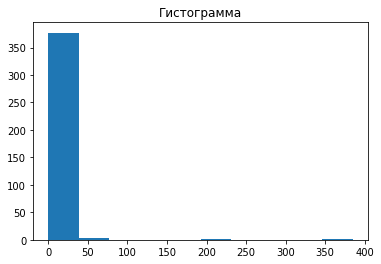

In [79]:
info_digital(stud.absences)

In [80]:
#Как один из варинтов на этом этапе
#пропущенные значения можно заменить на моду. Т.к. видно, что среднее значение смещено
#stud.absences.fillna(stud.absences.mode()[0],inplace=True)

#Пока данные оставлены, как есть, и в результате следующих операций удаления выбросов,
#отстуствующие значения отфильтруются.

По полученным данных видно, что исходная оценка среднего значения числа пропущенных занятий, сильно смещена, т.к. в выборке присутствуют выбросы. Исключим их.

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


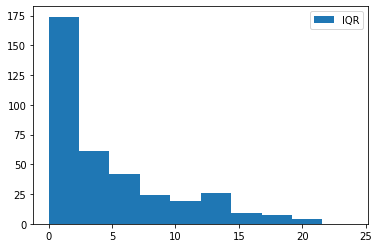

In [81]:
vubros(stud.absences)

In [82]:
#Находим границы интервалов и отфильтруем данные - удалим выбросы
f,l=interval_vaubros(stud.absences)
stud = stud.loc[stud.absences.between(f, l)]

Количество пропущенных значений: 0

Расспределение уникальных значений:


,absences
0.0,111
2.0,60
4.0,53
6.0,31
8.0,21
10.0,17
12.0,12
14.0,12
3.0,8
16.0,7


Основная статистика:


,absences
count,366.000000
mean,4.603825
std,4.965512
min,0.000000
25%,0.000000
50%,4.000000
75%,7.000000
max,20.000000


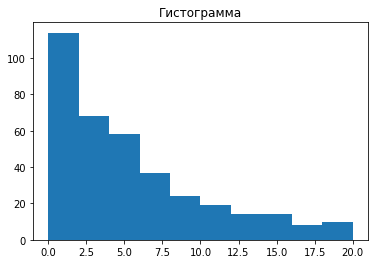

In [83]:
#Посмотрим еще раз на статистику
info_digital(stud.absences)

## score

Результативный признак score — баллы по госэкзамену по математике

Количество пропущенных значений: 5

Расспределение уникальных значений:


,score
50.0,53
55.0,42
0.0,36
75.0,31
65.0,30
60.0,29
70.0,27
40.0,26
45.0,23
80.0,16


Основная статистика:


,score
count,361.000000
mean,51.994460
std,22.956117
min,0.000000
25%,40.000000
50%,55.000000
75%,70.000000
max,100.000000


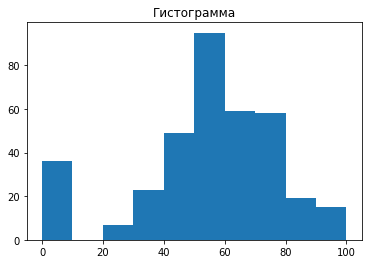

In [84]:
# Основная статистика по числовому признаку
info_digital(stud.score)

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


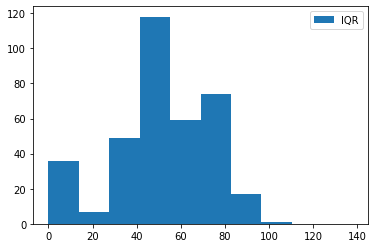

In [85]:
# Проверка на выбросы
vubros(stud.score)

По полученной статистике, можно сделать вывод, что выбросов нет. Пропущенные значения, можно заменить модой или медианой, они практически совпадают, что позволяет выдвинуть гипотезу о нормальном законе распределения.

In [86]:
# заменяем пропущенные значения на моду
stud.score.fillna(stud.score.mode()[0], inplace=True)

In [87]:
# тест на проверку распределения величины по нормальному закону
test_normal(stud.score.tolist(), 0.05)

H0: случайная величина подчиняется нормальному закону
H1: случайная величина не распределена по нормальному закону
Уровень значимости: 0.05
----------------------------------------------------------------------------
p-value: 5.998968245497653e-08
H0 отклоняется, H1 принимается - случайная величина не подчиняется нормальному закону


# Корреляционный анализ

In [88]:
# Построим корреляционную матрицу для численных переменных
stud[['age', 'absences', 'score']].corr()

,age,absences,score
age,1.000000,0.151493,-0.158496
absences,0.151493,1.000000,0.081197
score,-0.158496,0.081197,1.000000


Все парные коэффициенты корреляции не превосходят 0,7, следовательно мультиколлинеарности нет, признаки удалять нет необходимости.

# Анализ номинативных признаков

In [89]:
# Составим список из названий колонок номинативных признаков
s = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
     'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic',
     'famrel', 'freetime', 'goout', 'health']

In [90]:
# функция для построения boxplot для номинотивных переменных
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=stud.loc[stud.loc[:, column].isin(
                    stud.loc[:, column].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

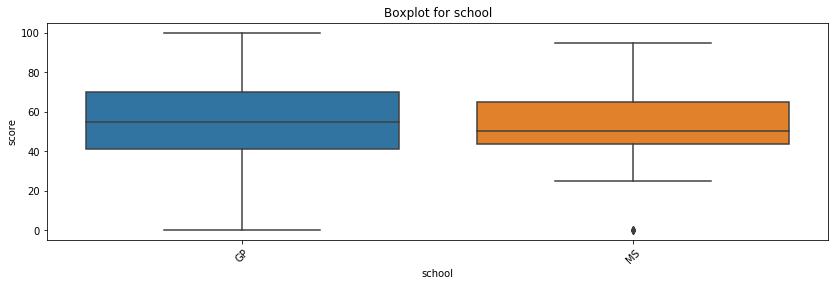

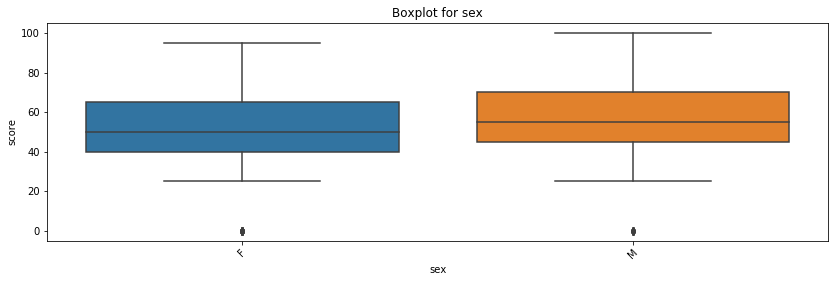

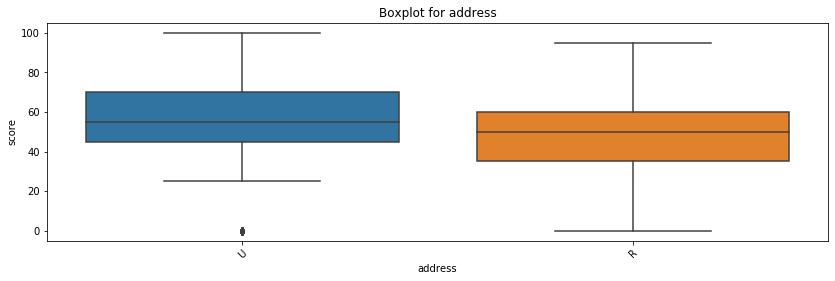

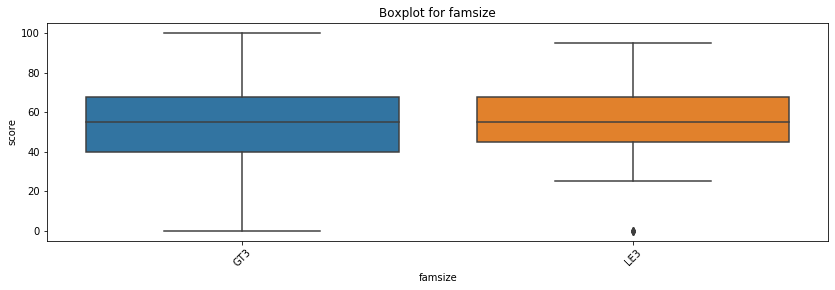

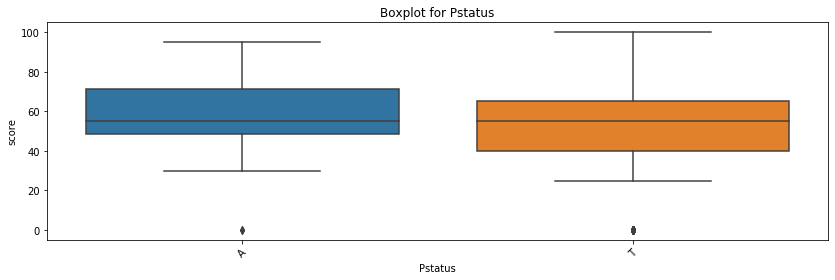

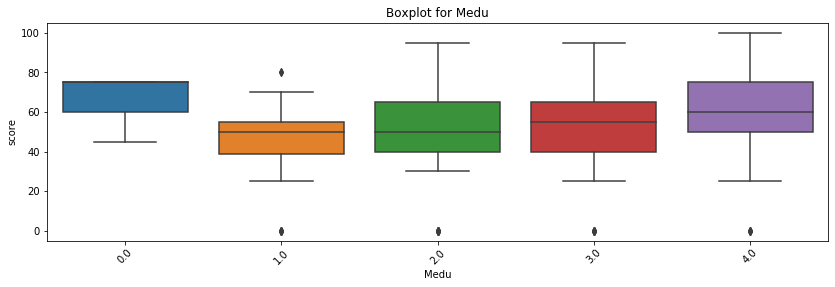

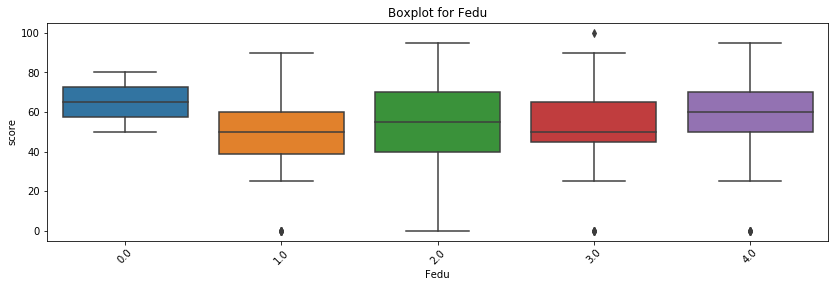

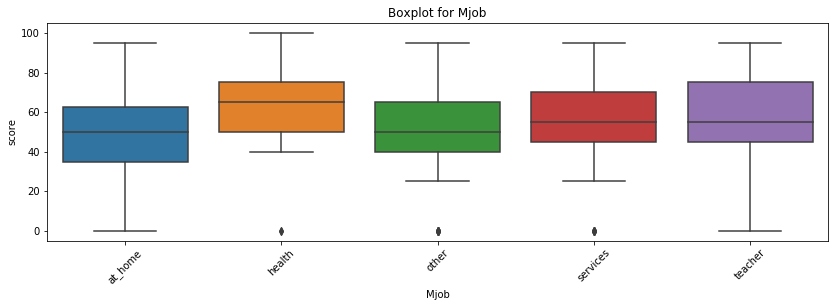

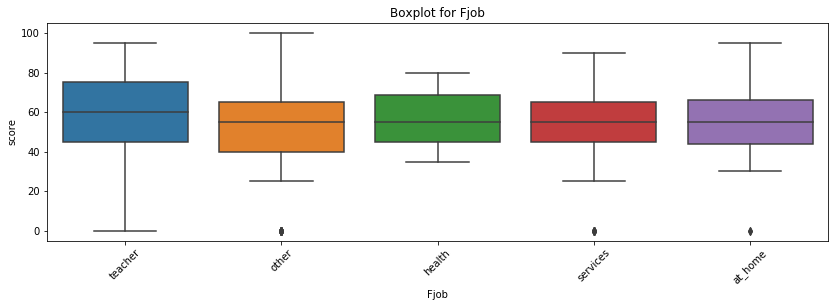

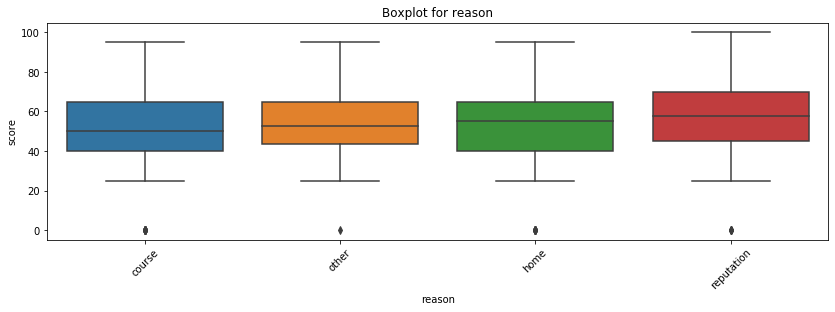

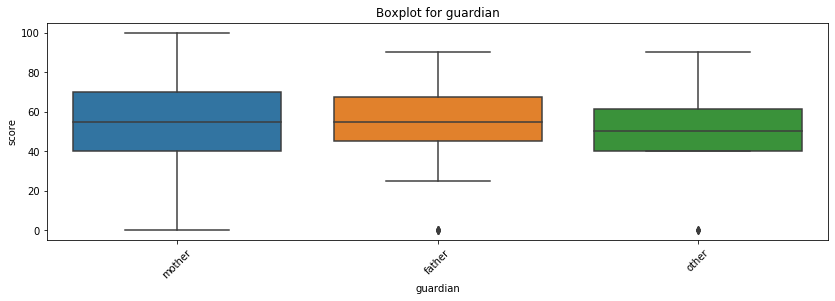

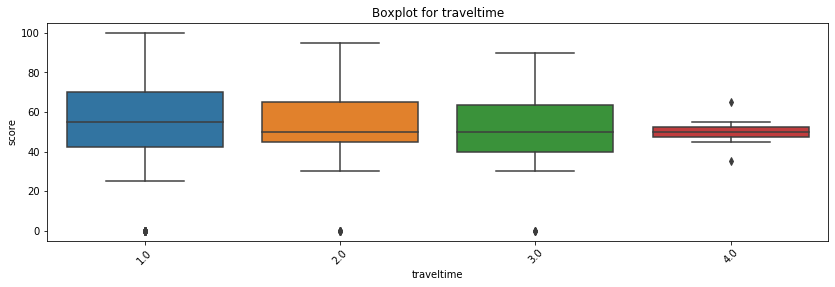

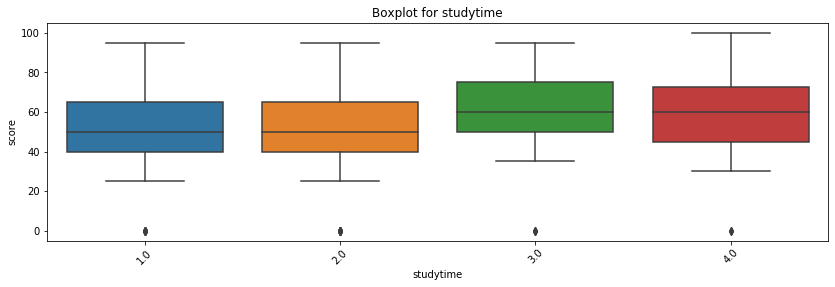

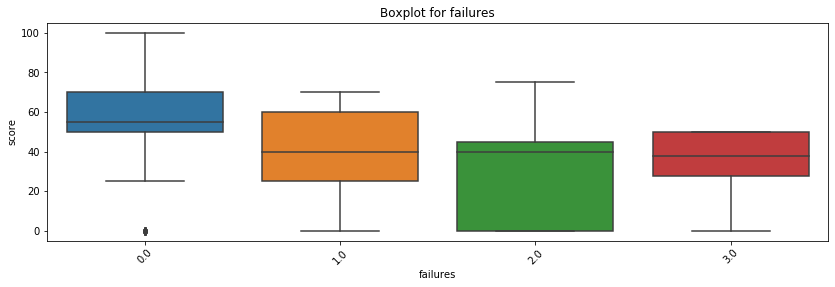

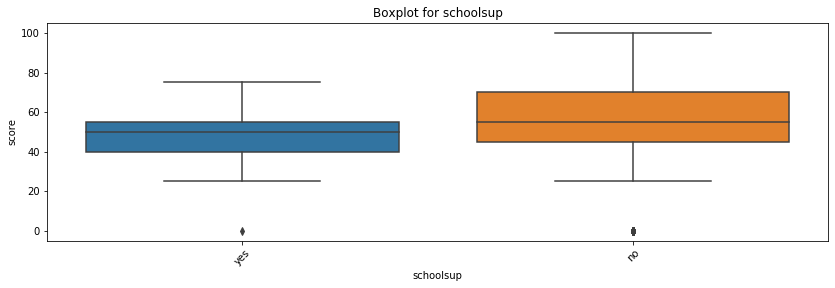

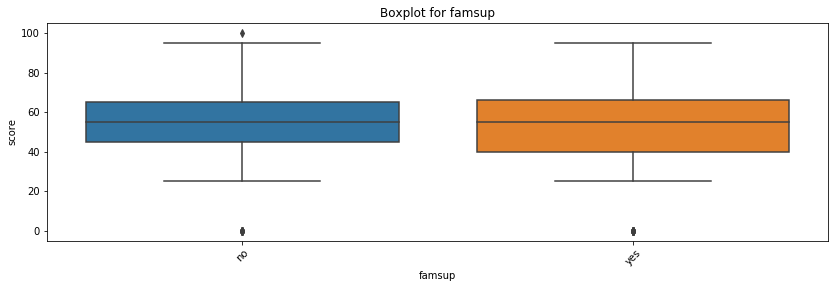

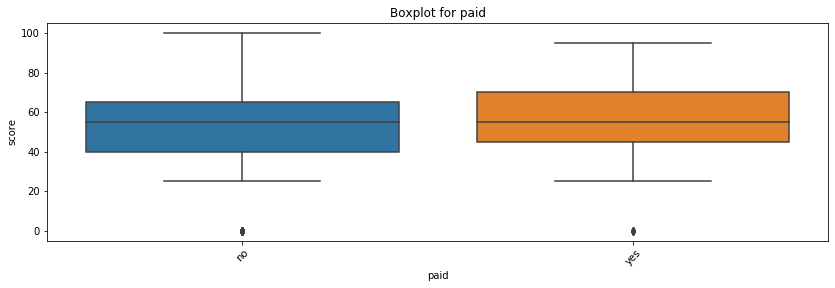

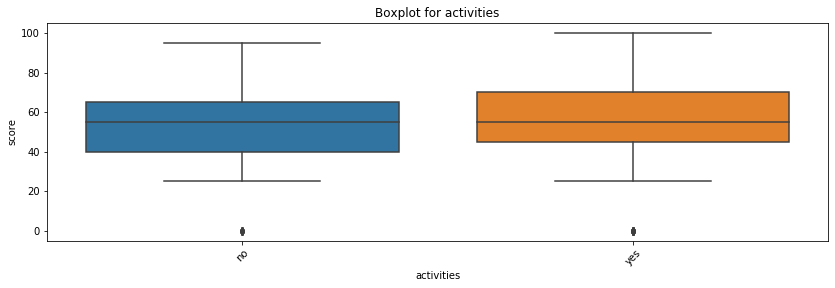

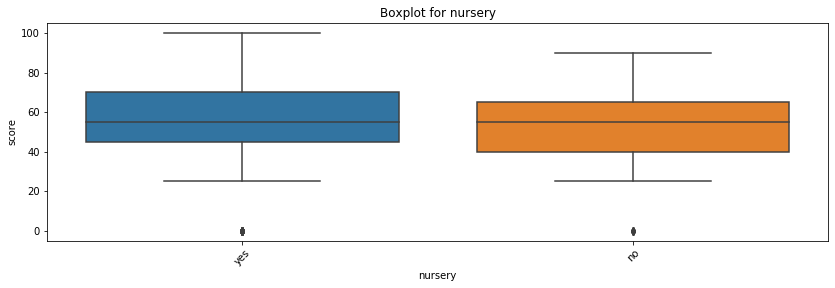

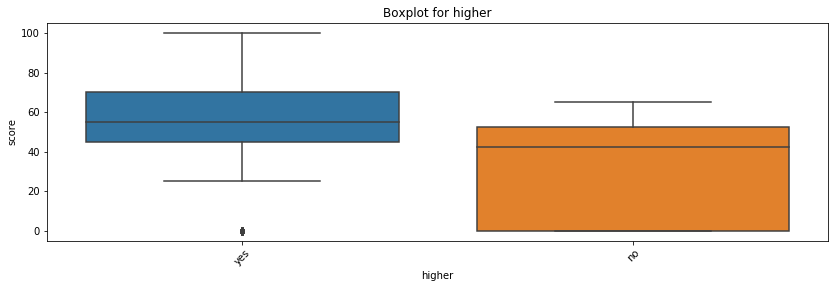

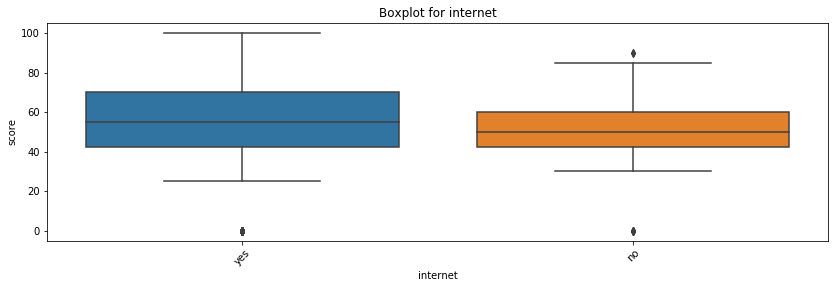

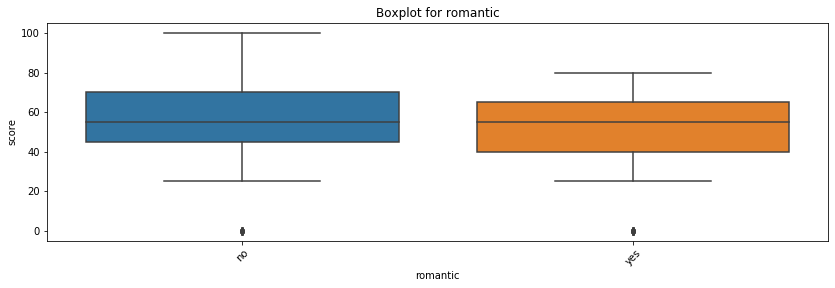

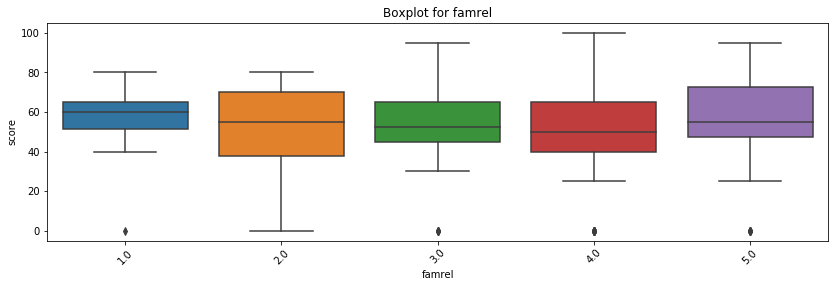

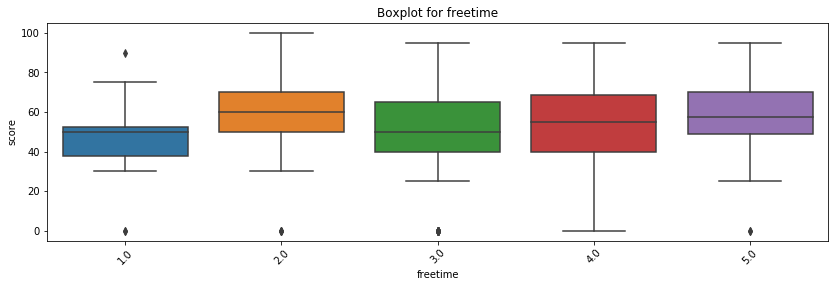

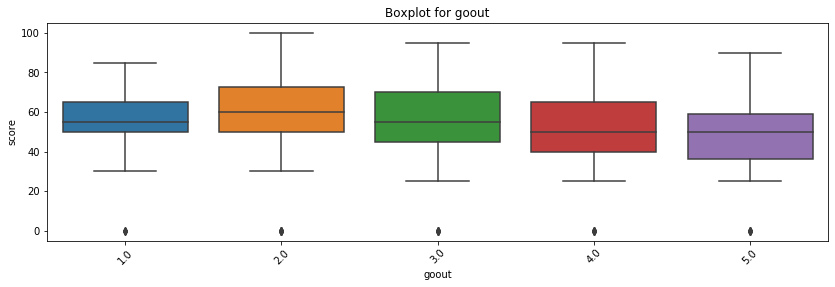

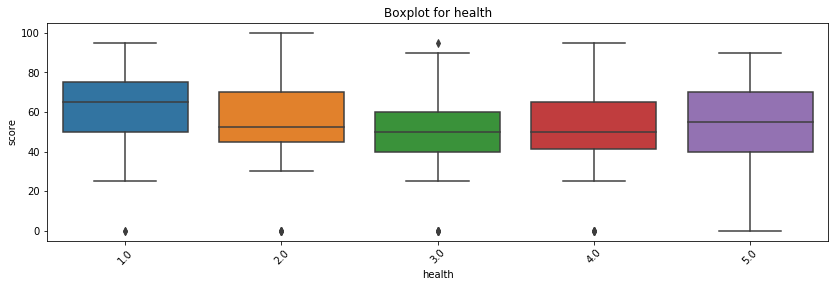

In [91]:
for col in s:
    get_boxplot(col)

In [92]:
def get_stat_dif(column):
    cols = stud.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud.loc[stud.loc[:, column] == comb[0], 'score'],
                     stud.loc[stud.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки - ', column)
            break

In [93]:
for col in s:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки -  sex
Найдены статистически значимые различия для колонки -  address
Найдены статистически значимые различия для колонки -  Medu
Найдены статистически значимые различия для колонки -  Mjob
Найдены статистически значимые различия для колонки -  failures
Найдены статистически значимые различия для колонки -  paid
Найдены статистически значимые различия для колонки -  higher
Найдены статистически значимые различия для колонки -  romantic


В результате теста, видно отличаются 8 параметров: sex, address, Medu, Mjob, failures, paid, higher, romantic. 
Оставим эти переменные в датасете для дальнейшего построения модели. Таким образом переменные, которые, возможно, 
оказывают влияние на оценку, это: age, absences, sex, address, Medu, Mjob, failures, paid, higher, romantic.

# Выводы

  В результате EDA для анализа влияния окружающих факторов учащихся на оценку по экзамеу по математике были получены следующие выводы:

-В данных присуствует много столбцов  с  пустыми значениями.

-Выбросы найдены только в столбце absences - количество пропущенных занятий, что позволяет сделать вывод о том, что данные достаточно чистые.

-Ошибочные данные наблюдались в столбцах Fedu (образование отца) и famrel (семейные отношения).

-Отрицательная корреляция между оценкой за экзамен и возрастом, говорит о том с увеличением возраста, оценка по экзамену уменьшается.

-Между двумя параметрами: количество пропущенных занятий и оценкой по математике за экзамен, коэффициент корреляции близок к нулю, т.е. связь между этими параметрами слабая или отсутствует совсем.

Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это  age, absences, sex, address, Medu, Mjob, failures, paid, higher, romantic.